# Quando finirà il Coronavirus🦠?

## **Grafico interattivo** del **Coronavirus** tracciato attraverso dati reali🌍 

I dati🔢 provengono dalla repository ufficiale della Protezione Civile italiana e vengono aggiornati ogni giorno. https://github.com/pcm-dpc/COVID-19

Costruito con Python e Jupyter Notebook

In [32]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

## Recupero degli ultimi dati

In [33]:
data_italy = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")

In [34]:
data_italy = data_italy.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
data_italy['data'] = data_italy['data'].map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days)
print("Dati degli ultimi sette giorni📅")
data[-7:]

Dati degli ultimi sette giorni📅


,data,totale_casi,differenza_giorno_precedente,tasso_crescita
74,128,217185,1327.0,0.6
75,129,218268,1083.0,0.5
76,130,219070,802.0,0.4
77,131,219814,744.0,0.3
78,132,221216,1402.0,0.6
79,133,222104,888.0,0.4
80,134,223096,992.0,0.4


## Calcolo funzione logistica

### La funzione utilizzata è una funzione sigmoidale
$$f(x; a, b, c) = \frac{c}{1 + e ^ -\dfrac{x - b}{a}}$$

**Vengono passati tre parametri:**
- **a**: Velocità dell'infezione (inizialmente 1)
- **b**: Il giorno del massimo delle infezioni
- **c**: Il numero totale di persone infette

La funzione è ricorsiva, ovvero richiama se stessa all'infinito fino a quando non si raggiunge un valore minimo -nel nostro caso 0, che corrisponde al totale appiattimento della curva.

In [35]:
def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

In [48]:
x = list(data.iloc[:,0])
y = list(data.iloc[:,1])
fit = curve_fit(
    logistic_model, 
    x, 
    y,
    p0=[1,max(x),max(y)]
)

speed, x_peak, y_max = fit[0]

### Trovo il picco

Dalla funzione logistica sono stati ricavati tre vettori che rappresentano l'andamento della curva giorno per giorno: 
- Velocità di crescita (speed)
- Punto di massimo sull'asse X (x_peak)
- Punto di massimo sull'asse Y (y_peak)

In [49]:
end = int(fsolve(lambda x : logistic_model(x, speed, x_peak, y_max) - int(y_max), x_peak))
end

223

### Grafico

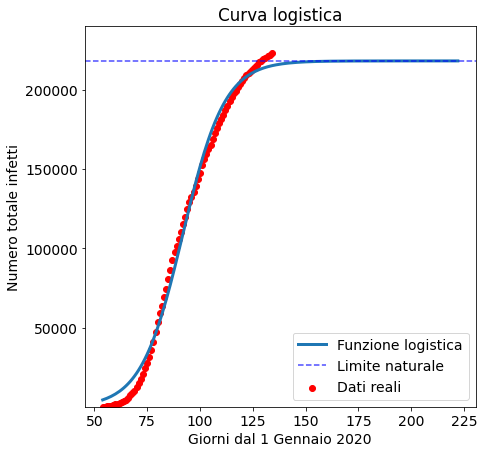

In [50]:
def plot_curve():
    pred_x = list(range(max(x), end))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Dati reali",color="red")
    # Predicted logistic curve
    plt.plot(x + pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x],linewidth=3, label="Funzione logistica" )
    plt.axhline(y=max([logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x]), color='blue', linestyle='dashed', alpha=0.7, linewidth=1.5, label='Limite naturale')

    plt.legend()
    plt.xlabel("Giorni dal 1 Gennaio 2020")
    plt.ylabel("Numero totale infetti")
    plt.title("Curva logistica")
    plt.ylim((min(y)*0.9,y_max*1.1))
    plt.show()
plot_curve()

Potete osservare che la curva è formata da due rami: uno esponenziale (parte bassa) e uno logaritmico (parte alta). La funzione cambia concavità nel punto di flesso nel centro della funzione


## Tasso di crescita

### Calcolo

In [51]:
data['differenza_giorno_precedente'] = data.diff()['totale_casi']
data['tasso_crescita'] = round(data['differenza_giorno_precedente'] / (data['totale_casi'] - data['differenza_giorno_precedente']) * 100, 1)
data["tasso_crescita"].fillna(0)
data["data"].fillna(0)
data[-7:]

,data,totale_casi,differenza_giorno_precedente,tasso_crescita
74,128,217185,1327.0,0.6
75,129,218268,1083.0,0.5
76,130,219070,802.0,0.4
77,131,219814,744.0,0.3
78,132,221216,1402.0,0.6
79,133,222104,888.0,0.4
80,134,223096,992.0,0.4


### Aggiornamento dataframe con i dati ottenuti dalla funzione logistica

In [52]:
d = {'data': x +pred_x, 'totale_casi': [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x + pred_x]}
df = pd.DataFrame(data=d)
df['differenza_giorno_precedente'] = df.diff()['totale_casi']
df['tasso_crescita'] = round(df['differenza_giorno_precedente'] / (df['totale_casi'] - df['differenza_giorno_precedente']) * 100, 1)
merge = pd.concat([data, df[df.data > max(data["data"])]])

### Grafico

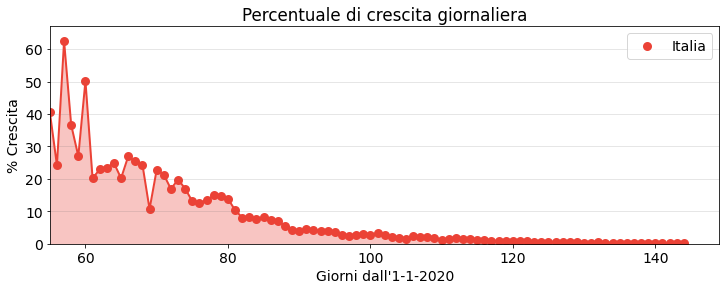

In [53]:
def infection_grow(x, y):
    plt.rc('font', size=14)
    plt.figure(figsize=(12, 4))
    plt_axes = plt.gca()
    plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
    plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
    plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
    plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="Italia", linewidth=3)
    plt.xlim(int(min(x)), int(max(x) + 5))
    plt.ylim(0, int(max(y)) + 5)
    plt.title("Percentuale di crescita giornaliera")
    plt.xlabel("Giorni dall'1-1-2020")
    plt.ylabel("% Crescita")
    plt.legend()
    plt.show()
infection_grow(merge[merge.tasso_crescita > 0]["data"].values.tolist(), merge[merge.tasso_crescita > 0]["tasso_crescita"].values.tolist())

## Quando raggiungeremo la fine?

In [54]:
end_date = datetime.strptime("2020-1-1", "%Y-%m-%d") + timedelta(days=end)
months = ["gennaio", "febbraio", "marzo", "aprile", "maggio", "giugno", "luglio", "agosto", "settembre", "ottobre", "novembre", "dicembre"] 
print("L'epidemia finirà in data " + str(end_date.day) + " " + months[end_date.month - 1] + " " + str(end_date.year))
print("Il numero dei contagiati sarà di " + str(int(round(y_max))))
peak_date = datetime.strptime("2020-1-1", "%Y-%m-%d") + timedelta(days=int(round(x_peak)))
print("Il picco è stato il " + str(peak_date.day) + " " + months[peak_date.month - 1] + " " + str(peak_date.year))

L'epidemia finirà in data 11 agosto 2020
Il numero dei contagiati sarà di 218146
Il picco è stato il 2 aprile 2020


La curva non rappresenta fedelmente la realtà in quanto non è possibile verificare il numero reale degli effetti: buona parte è sconosciuta poiché molte persone sono portatori asintomatici o hanno riscontrato lievi sintomi.   
Oltretutto se venisse deciso di effettuare tamponi a tappeto il numero dei contagi salirebbe parecchio, cambiando i valori della curva.

Osservando i dati degli ultimi giorni sembra che ci stiamo avvicinando all'asintoto della resistenza ambientale. Tuttavia non significa che siamo alla fine dell'isolamento, in quanto se le persone tornassero a circolare improvvisamente potrebbe esserci una ripresa dell'epidemia.